In [5]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

In [6]:
COE = pd.read_csv('COE_premiums_and_bids.csv')
REVAL = pd.read_csv('M10-Monthly_COE_Revalidation.csv')

In [7]:
COE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310 entries, 0 to 1309
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   month          1310 non-null   object
 1   bidding_no     1310 non-null   int64 
 2   vehicle_class  1310 non-null   object
 3   quota          1310 non-null   int64 
 4   bids_success   1310 non-null   int64 
 5   bids_received  1310 non-null   int64 
 6   premium        1310 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 71.8+ KB


# Extracting relevant Data (Cat A)

Looking at ONLY Cat A:

In [8]:
COEA=COE[COE["vehicle_class"]=="Category A"]
COEA=COEA.reset_index(drop=True)

REVALA=REVAL[REVAL["category"]=="Category A"]
REVALA=REVAL.reset_index(drop=True)

Set bidding made on 1st Monday of week to be 1, 3rd Monday of week: 15

In [9]:
i=0
length_df=len(COEA)
while(i<length_df):
    if(i%2==0):
        COEA["month"][i]=COEA["month"][i]+"-01"
    else:
         COEA["month"][i]=COEA["month"][i]+"-15"
    i+=1
COEA["month"]=pd.to_datetime(COEA["month"])

In [10]:
i=0
length_df=len(REVALA)
while(i<length_df):
    if(i%2==0):
        REVALA["month"][i]=REVALA["month"][i]+"-01"
    else:
         REVALA["month"][i]=REVALA["month"][i]+"-15"
    i+=1
REVALA["month"]=pd.to_datetime(REVALA["month"])

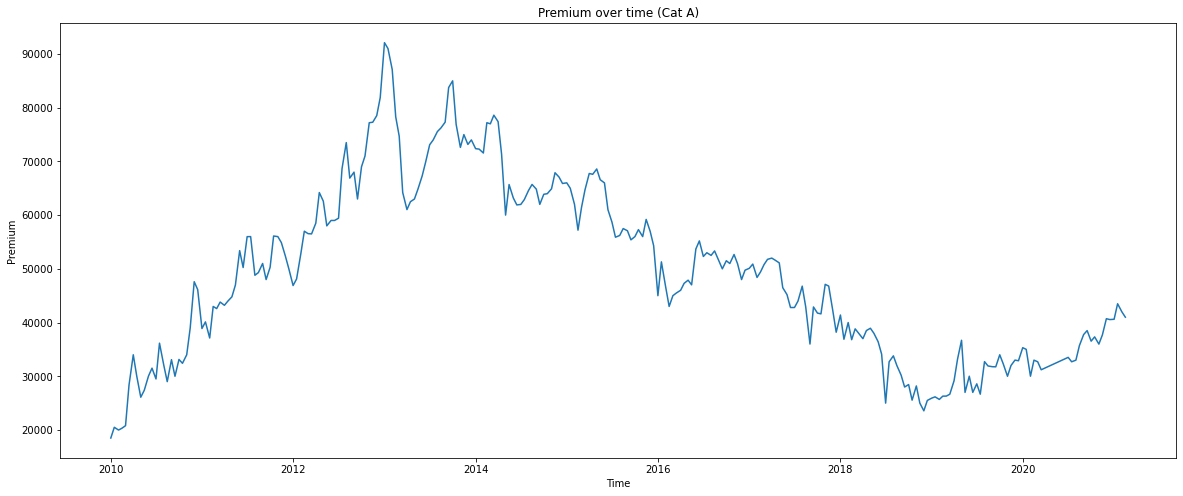

In [11]:
tp=COEA.groupby(["month"])["premium"].sum()
plt.figure(figsize=(20,8))
plt.title('Premium over time (Cat A)')
plt.xlabel('Time')
plt.ylabel('Premium')
plt.plot(tp)

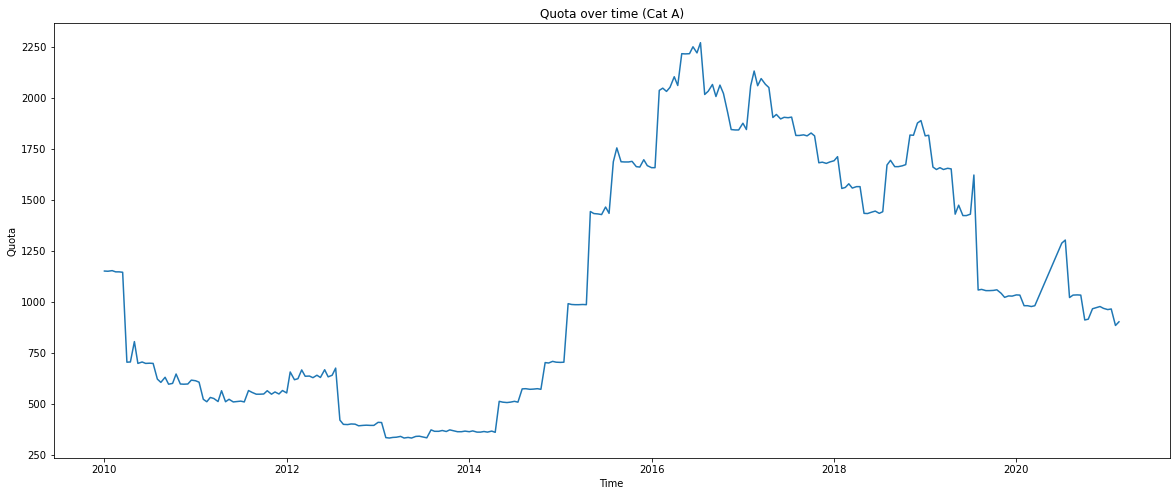

In [12]:
tp=COEA.groupby(["month"])["quota"].sum()
plt.figure(figsize=(20,8))
plt.title('Quota over time (Cat A)')
plt.xlabel('Time')
plt.ylabel('Quota')
plt.plot(tp)

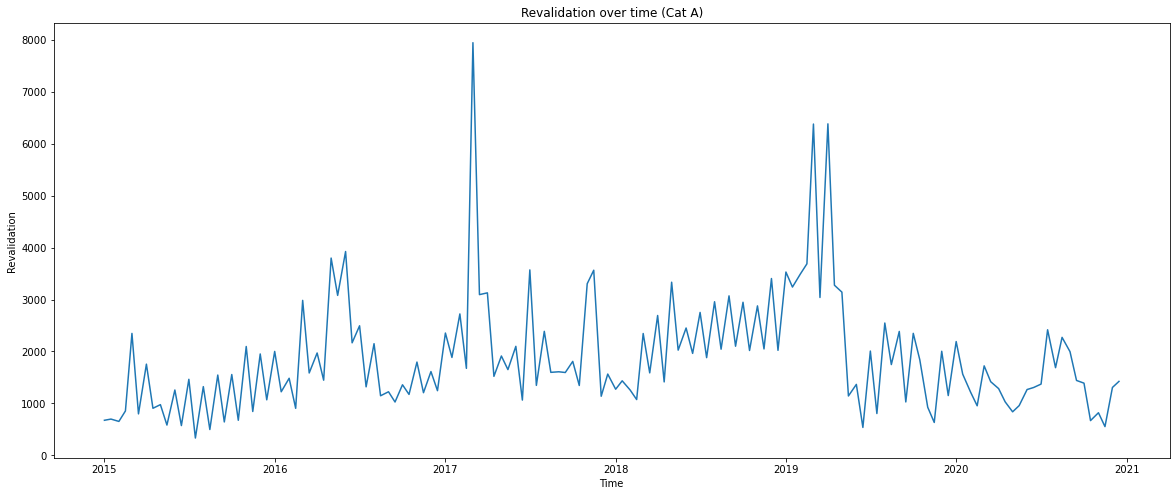

In [13]:
tp=REVALA.groupby(["month"])["number"].sum()
plt.figure(figsize=(20,8))
plt.title('Revalidation over time (Cat A)')
plt.xlabel('Time')
plt.ylabel('Revalidation')
plt.plot(tp)

In [14]:
COEA2019 = pd.DataFrame(COEA.iloc[216:])

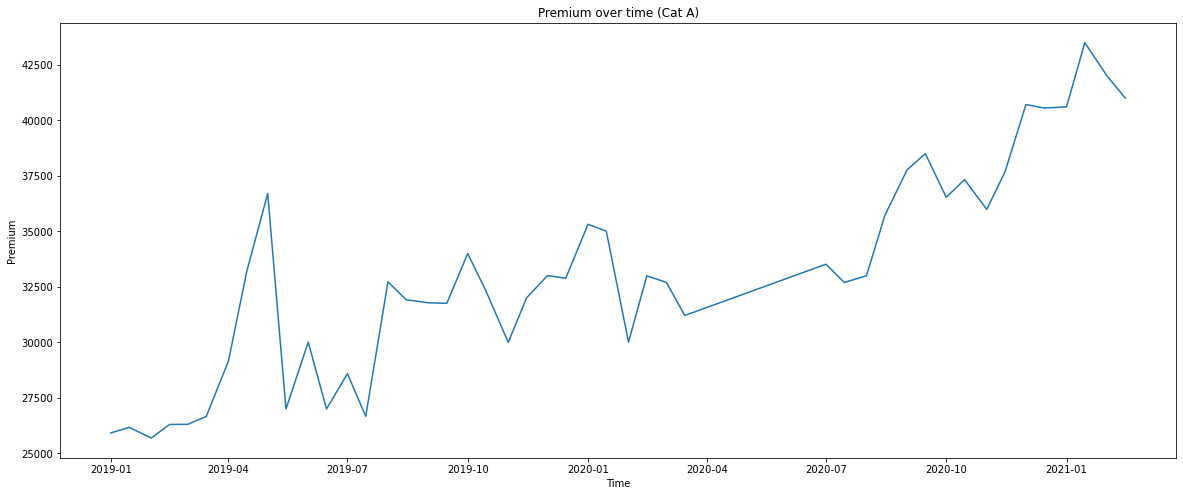

In [15]:
tp=COEA2019.groupby(["month"])["premium"].sum()
plt.figure(figsize=(20,8))
plt.title('Premium over time (Cat A)')
plt.xlabel('Time')
plt.ylabel('Premium')
plt.plot(tp)

# Checking stationality of Series

In [36]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window =6).mean()
    rolstd = timeseries.rolling(window =6).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

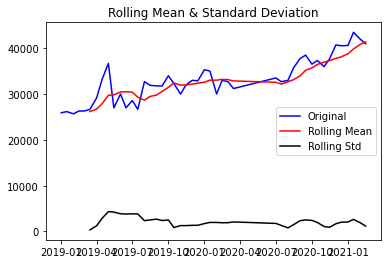

Results of Dickey-Fuller Test:
Test Statistic                  0.180149
p-value                         0.971126
#Lags Used                      6.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
Critical Value (5%)            -2.939109
Critical Value (10%)           -2.608063
dtype: float64


In [84]:
premium_a = COEA2019.groupby(["month"])["premium"].sum()
test_stationarity(premium_a)

Since test statistic not lesser than critical value,  we do not reject null hypothesis. Series is non-stationary.

# Making Series Stationary

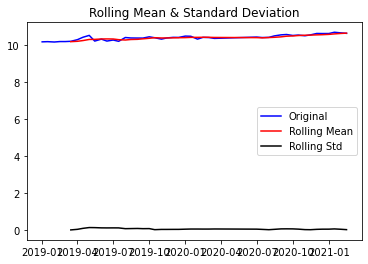

Results of Dickey-Fuller Test:
Test Statistic                 -0.268963
p-value                         0.929787
#Lags Used                      6.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
Critical Value (5%)            -2.939109
Critical Value (10%)           -2.608063
dtype: float64


In [85]:
a2019_log = np.log(premium_a)
test_stationarity(a2019_log)

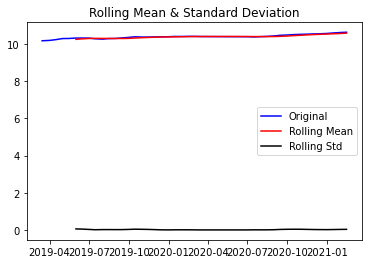

Results of Dickey-Fuller Test:
Test Statistic                  1.373884
p-value                         0.996992
#Lags Used                      7.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [86]:
a2019_log_moving_avg = a2019_log.rolling(6).mean()
a2019_log_moving_avg.dropna(inplace=True)
test_stationarity(a2019_log_moving_avg)

In [99]:
a2019_log_moving_avg_diff = a2019_log - a2019_log_moving_avg
a2019_log_moving_avg_diff.head(6)

month
2019-01-01         NaN
2019-01-15         NaN
2019-02-01         NaN
2019-02-15         NaN
2019-03-01         NaN
2019-03-15    0.018404
Name: premium, dtype: float64

Need to drop first 5 NaN values

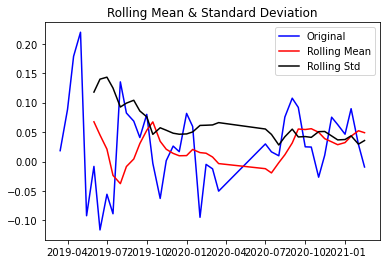

Results of Dickey-Fuller Test:
Test Statistic                -6.058208e+00
p-value                        1.230506e-07
#Lags Used                     4.000000e+00
Number of Observations Used    3.600000e+01
Critical Value (1%)           -3.626652e+00
Critical Value (5%)           -2.945951e+00
Critical Value (10%)          -2.611671e+00
dtype: float64


In [100]:
a2019_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(a2019_log_moving_avg_diff)

Series is stationary

#  AR and MA modeling

In [50]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf 

In [76]:
lag_acf = acf(a2019_log_moving_avg_diff, nlags=6)
lag_pacf = pacf(a2019_log_moving_avg_diff, nlags=6, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

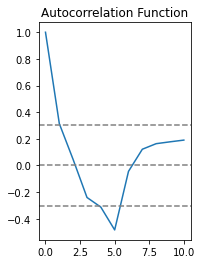

In [90]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(a2019_log_moving_avg_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(a2019_log_moving_avg_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

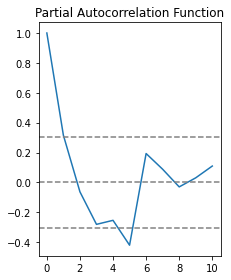

In [91]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(a2019_log_moving_avg_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(a2019_log_moving_avg_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

# Arima Model

In [59]:
from statsmodels.tsa.arima_model import ARIMA

Text(0.5, 1.0, 'RSS: 0.3335')

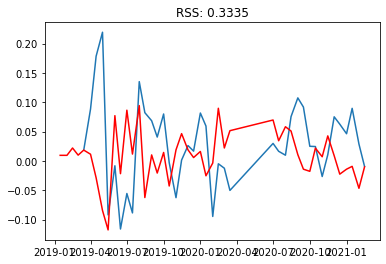

In [111]:
model = ARIMA(a2019_log, order=(2, 1, 2))  
results_AR = model.fit(disp=-1)  
plt.plot(a2019_log_moving_avg_diff)
plt.plot(results_AR.fittedvalues, color='red')
RSS = (results_AR.fittedvalues-a2019_log_moving_avg_diff)**2
RSS.dropna(inplace =True)
plt.title('RSS: %.4f'% sum(RSS))

In [113]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)

In [114]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

In [116]:
predictions_ARIMA_log = pd.Series(a2019_log[0], index=a2019_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

Text(0.5, 1.0, 'RMSE: 4193.7219')

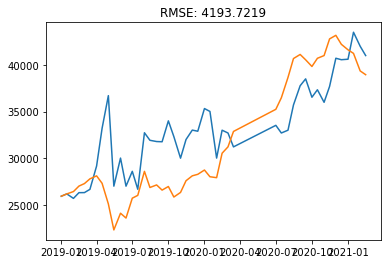

In [161]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(premium_a)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-premium_a)**2)/len(premium_a)))

In [121]:
premium_a.count()

46

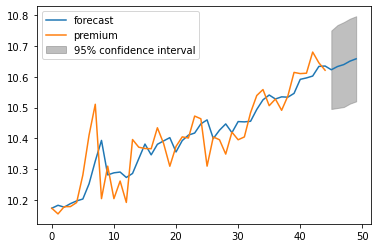

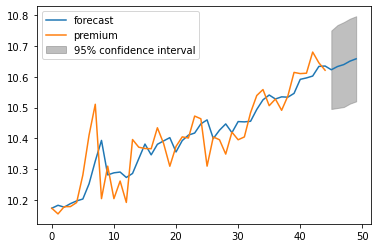

In [155]:
results_AR.plot_predict(1,50)

In [157]:
results_AR.forecast(steps = 4)
x = results_AR.forecast(steps = 4)

In [141]:
x[0]

array([10.62292323, 10.63348027, 10.63971593, 10.65093221])

In [160]:
predictions = np.exp(x[0])
predictions

array([41065.48357229, 41501.30990526, 41760.90654826, 42231.94522968])

### Maybe can do a prediction along with the revalidation number of vehicles.